In [ ]:
# March 2024
# Model training - pretrained language model
# Violeta Berdejo-Espinola

In [1]:
import torch
import torch.nn as nn

device = torch.device('mps')
print(device)

mps


In [ ]:
import mpu 

x  = mpu.io.read('../data/corpus_raw.pickle')
y = [1] * len(x[:62]) + [0] * len(x[62:])

pos = x[0:62]
neg = x[62:5020]

# split data

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# calculate weights for classes

weight_for_class_0 = len(x) / (len(neg) * 2) 
weight_for_class_1 = len(x) / (len(pos) * 2) 
class_weights = [weight_for_class_0, weight_for_class_1]
class_weights = torch.Tensor(class_weights).to(device)
class_weights

In [ ]:
0.0124*len(neg), 0.9876*len(pos)

In [9]:
len(neg)

4957

In [11]:
from transformers import AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
     
def tokenize(batch):
    return tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512)
    # returns dictionary with two key:value. input ids:tensors and attention mask:tensors both of them contain tensors
    
X_train = tokenize(x_train)                              
X_test = tokenize(x_test)

y_train = torch.tensor(y_train) 
y_test = torch.tensor(y_test) 

X_train['input_ids'].size()
X_test['input_ids'].size()

/var/folders/dz/szfgpm5s0tn_frclv0gl7m2c0000gr/T/ipykernel_16601/2799057607.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train)
/var/folders/dz/szfgpm5s0tn_frclv0gl7m2c0000gr/T/ipykernel_16601/2799057607.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test)


torch.Size([1004, 512])

In [10]:
len(X_train)

2

In [12]:
import random
from torch.utils.data import TensorDataset, DataLoader

batch_size = 128 # number of training samples in one forward and backwards pass
workers = 0      # how many subprocesses to use for data loading / each worker gets their own subset of indices to construct each batch. they retrieve data and put it into a queue
seed = 42
G = torch.Generator()
G.manual_seed(seed)

# function to seed workers in multiprocessing data loading

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# compile tensorDataset and DataLoaders

train_xlm = TensorDataset(X_train['input_ids'], X_train['attention_mask'], y_train)
train_dataloader = DataLoader(train_xlm,
                              batch_size=batch_size, 
                              shuffle=False, # set it to false so when dataset is split into batches, this isn't random
                              num_workers=workers, 
                              generator = G, # used to generate random indexes and multiprocessing to generate base seed for workers
                              worker_init_fn=seed_worker)


test_xlm = TensorDataset(X_test['input_ids'], X_test['attention_mask'], y_test)
test_dataloader = DataLoader(test_xlm, 
                            batch_size=batch_size,
                            shuffle=False, 
                            num_workers=workers, 
                            generator = G,
                            worker_init_fn=seed_worker)

In [14]:
from transformers import (XLMRobertaForSequenceClassification)

id2label = {'negative': 0, 'positive': 1}
label2id = {0: 'negative',1: 'positive'}

model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base',
                                                            num_labels=2, 
                                                            id2label=id2label, 
                                                            label2id=label2id).to(device)

# freeze transformer model parametres

for param in model.base_model.parameters():
    param.requires_grad = False

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# hyperparametres

num_epochs = 15
learning_rate = 0.1
optim = torch.optim.SGD(model.parameters(), lr = learning_rate)
criteria = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
# function to train model

def Trainer(epochs):

    loss_values = []
 
    for epoch in range(epochs):
        model.train() # set the model to training mode
        running_loss = 0
        
        # for step, batch in enumerate(dataloader):
        for batch in train_dataloader:

            input_ids = batch[0].to(device)
            input_mask = batch[1].to(device)
            target = batch[2].to(device)
            
            # clear gradients
            optim.zero_grad() 

            # forward pass
            outputs = model(input_ids,
                            token_type_ids=None,
                            attention_mask=input_mask)
            
            # logits from the model's output
            logits = outputs.logits
            # calculate loss
            loss = criteria(logits, target)
            # backward pass & compute gradients -> how each w and b should be tweaked to reduce the error
            loss.backward()
            # optimization & update parametres weights
            optim.step()
            
            # loss_values.append(standard cross entropy loss for the current model on the entire training set)
            loss_values.append(loss.item())
            running_loss += loss.item() 
            
        print(f"Epoch {epoch+1}/{num_epochs}, Loss {running_loss / len(train_dataloader)}")
    
    return loss_values

In [ ]:


# Store the average loss after each epoch 
loss_values = []

# number of total steps for each epoch
print('total steps per epoch: ',  len(train_dataloader) / batch_size)

# looping over epochs
for epoch_i in range(0, epochs):
    
    print('training on epoch: ', epoch_i)
   
    # reset total loss
    total_loss_2 = 0
    
    # model in training 
    model.train()
    
    # loop through batch 
    for step, batch in enumerate(train_dataloader):
            
        # load data from dataloader 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # clear any previously calculated gradients 
        model.zero_grad()
        
        # get outputs
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        # get loss
        loss = outputs[0]
        
        # total loss
        total_loss += loss.item()
        
        # clip the norm of the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # update optimizer
        optim.step()
        
        # update learning rate 
        scheduler.step()
        
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("average training loss: {0:.4f}".format(avg_train_loss))

In [ ]:
import random
import time
import numpy as np

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# lr: 0.001
losses0  = Trainer(train_dataloader, num_epochs)

Epoch 1/3, Loss 0.6857520509511232
Epoch 2/3, Loss 0.68518309853971
Epoch 3/3, Loss 0.686144077219069


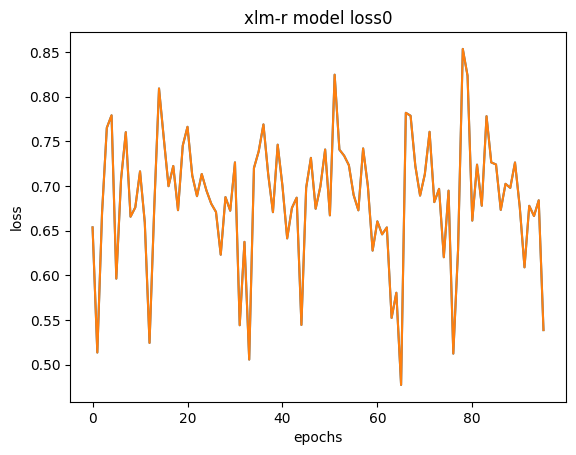

In [22]:
import matplotlib.pyplot as plt

plt.plot(losses0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('xlm-r model loss0')

plt.plot(losses0)

In [ ]:
# lr: 0.001
losses1 = Trainer(train_dataloader, num_epochs)

Epoch 1/3, Loss 0.6920430790632963
Epoch 2/3, Loss 0.6788655705749989
Epoch 3/3, Loss 0.6852124659344554


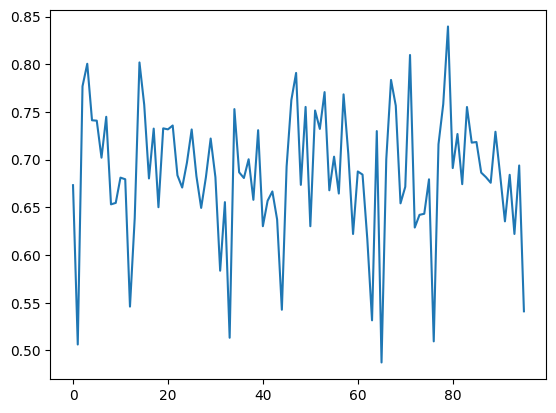

In [ ]:
plt.plot(losses1)

In [ ]:
# lr: 0.001
losses3  = Trainer(train_dataloader, num_epochs)

Epoch 1/15, Loss 0.6935548605397344
Epoch 2/15, Loss 0.6845838986337185
Epoch 3/15, Loss 0.6784735219553113
Epoch 4/15, Loss 0.6827346887439489
Epoch 5/15, Loss 0.6883183233439922
Epoch 6/15, Loss 0.6828462854027748
Epoch 7/15, Loss 0.689664407633245
Epoch 8/15, Loss 0.6818316923454404
Epoch 9/15, Loss 0.6885982304811478
Epoch 10/15, Loss 0.6757809277623892
Epoch 11/15, Loss 0.690578943118453
Epoch 12/15, Loss 0.6863315291702747
Epoch 13/15, Loss 0.6843488654121757
Epoch 14/15, Loss 0.6908072866499424
Epoch 15/15, Loss 0.685244076885283


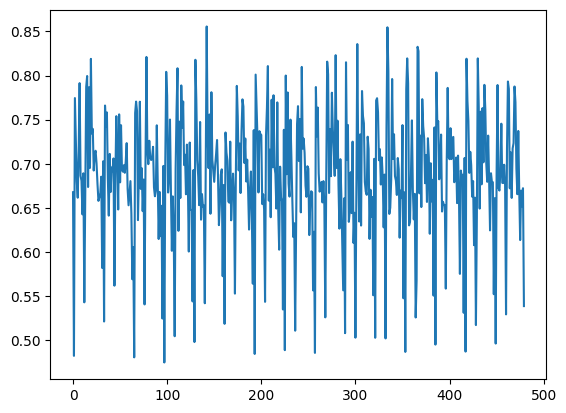

In [31]:
plt.plot(losses3)

In [39]:
# lr:0.01
losses4 = Trainer(train_dataloader, num_epochs)

Epoch 1/15, Loss 0.7266187248751521
Epoch 2/15, Loss 0.7285053012892604
Epoch 3/15, Loss 0.7039568377658725
Epoch 4/15, Loss 0.7049516895785928
Epoch 5/15, Loss 0.6962169464677572
Epoch 6/15, Loss 0.703656560741365
Epoch 7/15, Loss 0.6976663498207927
Epoch 8/15, Loss 0.698989687487483
Epoch 9/15, Loss 0.6868411879986525
Epoch 10/15, Loss 0.6952825700864196
Epoch 11/15, Loss 0.7014201059937477
Epoch 12/15, Loss 0.6843609660863876
Epoch 13/15, Loss 0.6813403768464923
Epoch 14/15, Loss 0.6818724712356925
Epoch 15/15, Loss 0.677359227091074


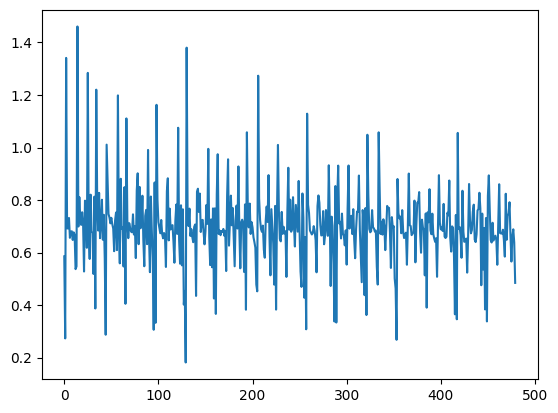

In [40]:
plt.plot(losses4)

In [44]:
# lr:0.1
losses5 = Trainer(train_dataloader, num_epochs)

Epoch 1/15, Loss 0.9188246782869101
Epoch 2/15, Loss 0.7360865259543061
Epoch 3/15, Loss 0.701129486784339
Epoch 4/15, Loss 0.7455280562862754
Epoch 5/15, Loss 0.7021764554083347
Epoch 6/15, Loss 0.6925088809803128
Epoch 7/15, Loss 0.698815849609673
Epoch 8/15, Loss 0.7193861268460751
Epoch 9/15, Loss 0.7052717553451657
Epoch 10/15, Loss 0.7106485227122903
Epoch 11/15, Loss 0.7105446895584464
Epoch 12/15, Loss 0.7218462033197284
Epoch 13/15, Loss 0.6856941124424338
Epoch 14/15, Loss 0.7082144888117909
Epoch 15/15, Loss 0.6986055234447122


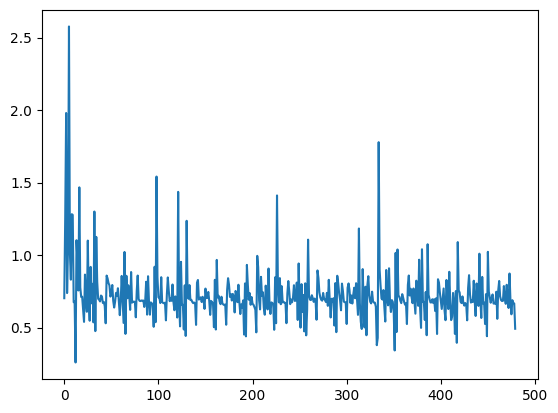

In [122]:
plt.plot(losses5)

plt.savefig('../results/loss_nn_lr=0.1.png', dpi=800)

In [72]:
# evaluate

from sklearn.metrics import confusion_matrix, classification_report
import torch.nn.functional as nn

def evaluate_model(dataloader):
    model.eval()  # set the model to evaluation mode

    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    
    with torch.no_grad():  # disable gradient calculations
        for batch in dataloader:
            
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            target = batch[2].to(device)

            # forward pass
            outputs = model(input_ids, attention_mask=attention_mask) # z=g(wx+b)
            logits = outputs.logits # unnormalized score of the mdoel # g(z) 
            
            # get predicted proba -> apply softmax to get a probability distribution over classes: class 0 + class 1 = 1
            probabilities = nn.softmax(logits, dim=1)
            
            # get the predicted class 
            predictions = torch.argmax(logits, dim=-1)
        
            all_probabilities.extend(probabilities.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
            
    return all_predictions, all_labels, all_probabilities

In [73]:
all_predictions, all_labels, all_probabilities = evaluate_model(test_dataloader)

from sklearn.metrics import confusion_matrix, classification_report
cr = classification_report(all_labels, 
                           all_predictions, 
                           output_dict=False)
print(cr)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       991
           1       0.00      0.00      0.00        13

    accuracy                           0.99      1004
   macro avg       0.49      0.50      0.50      1004
weighted avg       0.97      0.99      0.98      1004



/Users/uqvberde/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/uqvberde/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/uqvberde/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


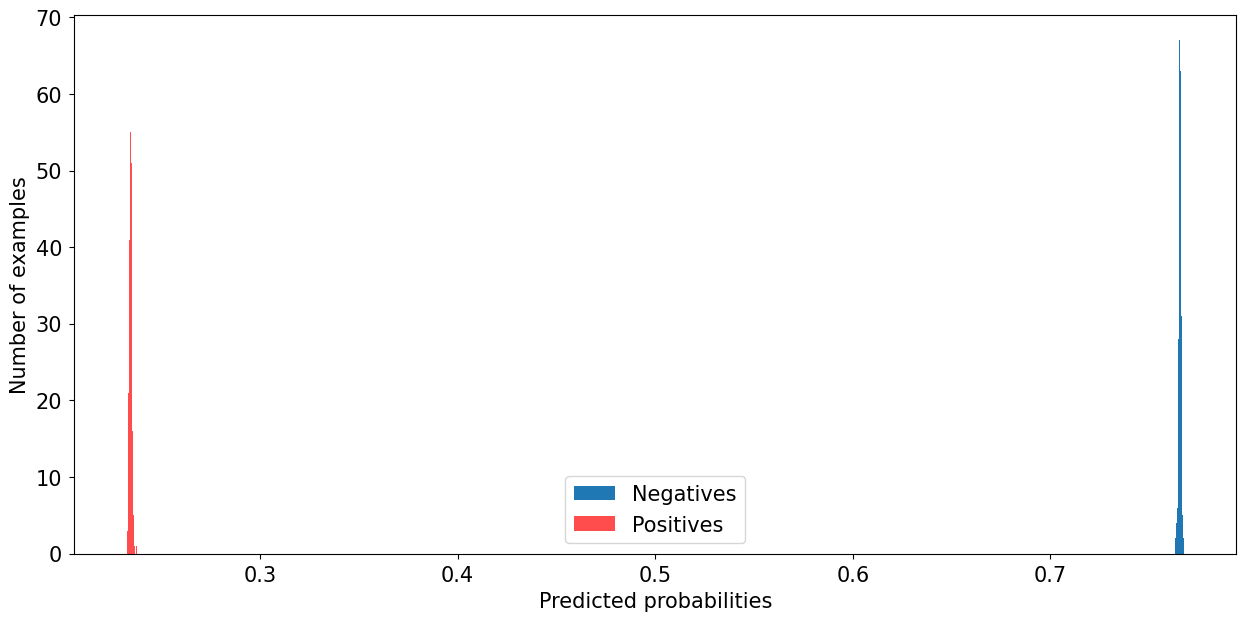

<Figure size 640x480 with 0 Axes>

In [126]:
import matplotlib.pyplot as plt

y_pred_ts_p = [array[1] for array in all_probabilities] # subset class of interest --> 1d array
y_pred_ts_n = [array[0] for array in all_probabilities]

plt.figure(figsize=(15,7))
plt.hist(y_pred_ts_n, bins=50, label='Negatives')
plt.hist(y_pred_ts_p, bins=50, label='Positives', alpha=0.7, color='r')
plt.xlabel('Predicted probabilities', fontsize=15)
plt.ylabel('Number of examples', fontsize=15)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=15, pad=5)
plt.show() 

plt.savefig('../results/predicted_proba_nn_lr=0.1_2.png', dpi=800)

In [111]:
data[:10]

array([[0.76443636, 0.7648826 , 0.7650757 , ..., 0.7665939 , 0.76503897,
        0.7657654 ],
       [0.23556365, 0.23511738, 0.23492436, ..., 0.23340611, 0.234961  ,
        0.2342346 ]], dtype=float32)

In [117]:
data[:10].shape

(2, 1004)

In [116]:
data

array([[0.76443636, 0.7648826 , 0.7650757 , ..., 0.7665939 , 0.76503897,
        0.7657654 ],
       [0.23556365, 0.23511738, 0.23492436, ..., 0.23340611, 0.234961  ,
        0.2342346 ]], dtype=float32)

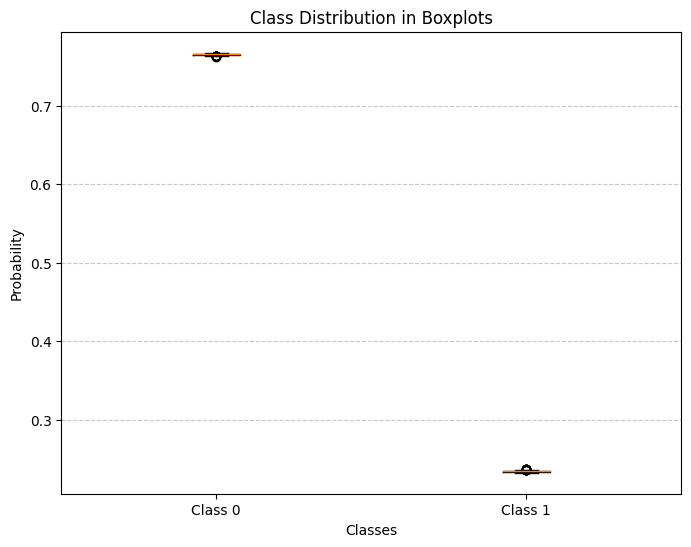

<Figure size 640x480 with 0 Axes>

In [128]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the boxplots
plt.figure(figsize=(8, 6))
plt.boxplot(data.T, labels=['Class 0', 'Class 1'])
plt.title("Class Distribution in Boxplots")
plt.ylabel("Probability")
plt.xlabel("Classes")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.savefig('../results/predicted_proba_nn_lr=0.1.pdf', dpi=800)



In [76]:
all_probabilities[:3], all_predictions[:3], all_labels[:30]

([array([0.76443636, 0.23556365], dtype=float32),
  array([0.7648826 , 0.23511738], dtype=float32),
  array([0.7650757 , 0.23492436], dtype=float32)],
 [0, 0, 0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0])